# Check probe

author: steeve.laquitaine@epfl.ch

Pipeline:

```bash
sbatch cluster/processing/marques_vivo/process.sbatch
```

In [1]:
# SET PACKAGES
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import MEAutility as MEA
import spikeinterface as si
import scipy
from probeinterface import (
    Probe,
    )

# SET PATHS
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"

os.chdir(PROJ_PATH)
from src.nodes.dataeng.silico import probe_wiring
from src.nodes.utils import get_config

# SETUP CONFIG
data_conf, param_conf = get_config("vivo_marques", "c26").values()
RECORDIND_PATH = data_conf["probe_wiring"]["input"]
WIRED_PATH = data_conf["probe_wiring"]["output"]
CHANNEL_MAP_FILE = data_conf["channel_map"]

2024-01-19 13:52:26,161 - root - utils.py - get_config - INFO - Reading experiment config.
2024-01-19 13:52:26,173 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Wire probe

In [2]:
# get Neuropixels-384 as a model to replicate
npx_prms = MEA.return_mea_info("Neuropixels-384")

# get the channel locations from the Recording
# load authors' channel map file and channel locations
channel_map = scipy.io.loadmat(CHANNEL_MAP_FILE)
locations = np.zeros((384, 2))
locations[:, 0] = channel_map["xcoords"][:, 0]
locations[:, 1] = channel_map["ycoords"][:, 0]

# create 2D probe with the locations
Probe_vivo = Probe(ndim=2, si_units="um")
Probe_vivo.set_contacts(
    positions=locations,
    shapes=npx_prms["shape"],
    shape_params={
        "width": npx_prms["size"],
    },
)
Probe_vivo.create_auto_shape(probe_type="tip")

# cast as SpikeInterface Recording object
# should have been casted beforehand
Recording = si.load_extractor(RECORDIND_PATH)

# set contact and channel ids (mapped to the rows of the locations array)
Probe_vivo.set_contact_ids(np.arange(0, 384, 1))  # default order in Kilosort
Probe_vivo.set_device_channel_indices(Recording.get_channel_ids())

# wire probe
Probed = Recording.set_probe(Probe_vivo)

### Plot

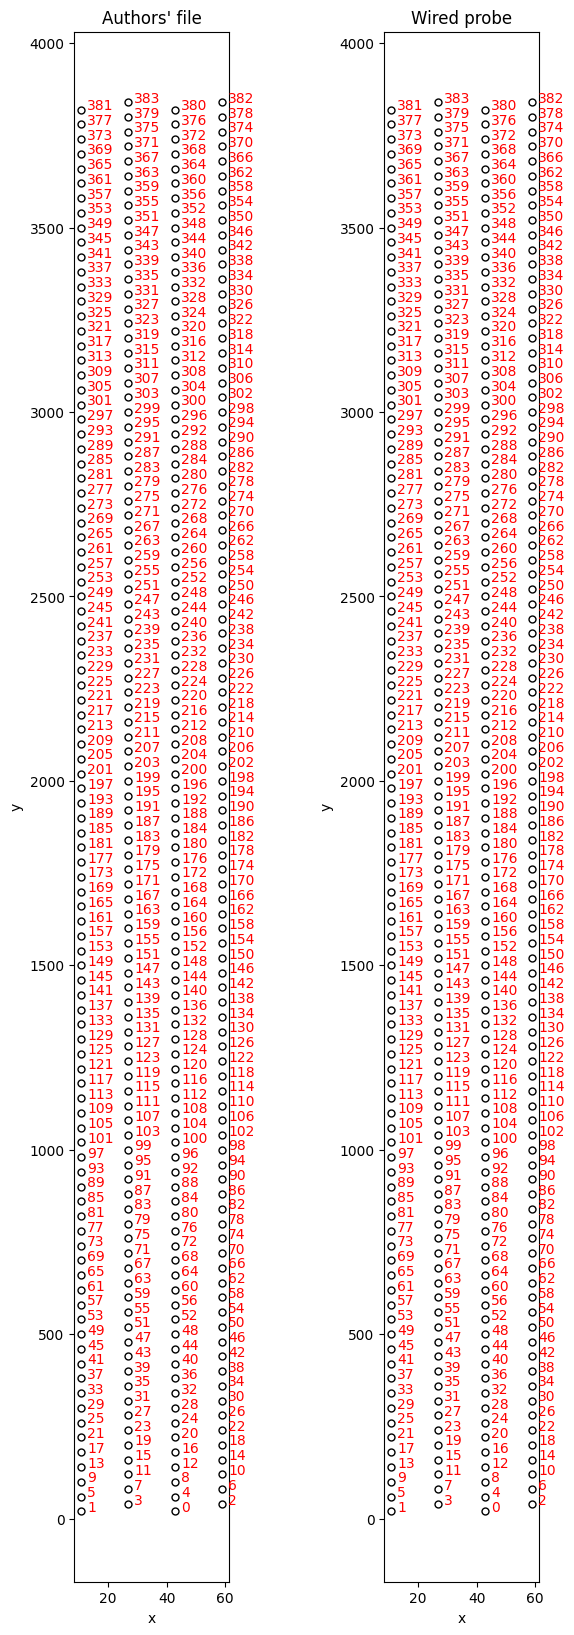

In [8]:
# probed
channel_locations = Probed.get_channel_locations()
channel_ids = Probed.get_channel_ids()


# PLOT LOCATIONS FROM AUTHORS' FILE
fig, ax = plt.subplots(1, 2, figsize=(6, 40))

ax[0].plot(
    locations[:, 0],
    locations[:, 1],
    "o",
    markersize=5,
    markerfacecolor="w",
    color="k",
)


for ix in range(len(channel_locations)):
    if ix % 1 == 0:
        ax[0].text(
            locations[ix, 0] + 2,
            locations[ix, 1],
            "%s" % (str(Recording.get_channel_ids()[ix])),
            size=10,
            zorder=100,
            color="r",
        )
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_box_aspect(10)
ax[0].set_title("Authors' file")

# PLOT WIRED PROBE LOCATIONS

ax[1].plot(
    channel_locations[:, 0],
    channel_locations[:, 1],
    "o",
    markersize=5,
    markerfacecolor="w",
    color="k",
)

for ix in range(len(channel_locations)):
    if ix % 1 == 0:
        ax[1].text(
            channel_locations[ix, 0] + 2,
            channel_locations[ix, 1],
            "%s" % (str(channel_ids[ix])),
            size=10,
            zorder=100,
            color="r",
        )
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_box_aspect(10)
ax[1].set_title("Wired probe")

fig.subplots_adjust(wspace=1)